# Photonic Band Gap, lab report

In [104]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pprint import pprint
import scipy
import utils

%matplotlib inline

# minimal plot style
plt.rcParams['figure.figsize'] = [10, 5]

# import all the runs in the dataframe
prj_path = os.getcwd()
rel_path = 'labeldata'
full_path = os.path.join(prj_path, rel_path)
files = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
print(f'importing these files:')
pprint(files, compact=True)

df = pd.concat([pd.read_csv(os.path.join(rel_path, file)) for file in files])
print(f"list of measured samples: {df['sample'].unique()}")

df

importing these files:
['30-05-24_R0.txt', '30-05-24_R1.txt', '30-05-24_R2.txt', '30-05-24_R3.txt',
 '30-05-24_R4.txt', '30-05-24_R5.txt', '30-05-24_R6.txt', '20-06-24_R0.txt',
 '20-06-24_R1.txt', '20-06-24_R2.txt', '20-06-24_R3.txt', '20-06-24_R4.txt',
 '20-06-24_R5.txt', '20-06-24_R6.txt', '20-06-24_R7.txt', '20-06-24_R8.txt',
 '20-06-24_R9.txt', '20-06-24_R10.txt', '20-06-24_R11.txt', '20-06-24_R12.txt',
 '20-06-24_R13.txt', '20-06-24_R14.txt', '20-06-24_R15.txt', '20-06-24_R16.txt',
 '20-06-24_R17.txt', '20-06-24_R18.txt']
list of measured samples: ['AIR' 'SIL' 'PCR' 'CAL' 'BOX']


,id,frequency_GHz,peak_mV,sigma_peak_mV,noise_mV,sigma_noise_mV,sample,antenna
0,30-05-24_R0,0.250000,6.89000,NaN,0.210000,NaN,AIR,LF
1,30-05-24_R0,0.333333,6.82000,NaN,0.192000,NaN,AIR,LF
2,30-05-24_R0,0.416667,7.13000,NaN,0.226000,NaN,AIR,LF
3,30-05-24_R0,0.500000,6.62000,NaN,0.225000,NaN,AIR,LF
4,30-05-24_R0,0.583333,6.81000,NaN,0.203000,NaN,AIR,LF
...,...,...,...,...,...,...,...,...
75,20-06-24_R18,5.708860,2.11948,0.237872,0.617500,0.004037,SIL,LF
76,20-06-24_R18,5.781650,2.17700,0.380156,0.651000,0.020746,SIL,LF
77,20-06-24_R18,5.854430,1.80896,0.262637,0.652500,0.008019,SIL,LF
78,20-06-24_R18,5.927220,1.75095,0.339404,0.678167,0.009196,SIL,LF


## Analisi della distorsione del segnale

Come prima cosa è opportuno valutare la presenza di artefatti dell'apparato di misura che andranno sottratti dal segnale. 
Sia il generatore che l'analizzatore danno delle risposte diverse a diverse frequenze, ad esempio il generatore produce un segnale più intenso a basse frequenze, e così via. Ci sono anche gli effetti prodotti dalla scatola con la schermatura, essa produce delle onde stazionarie e delle risonanze che si sommano all'effetto del cristallo fotonico.
In particolare l'analisi del rumore deve tenere conto di:

- distorsioni del generatore e del ricevitore in presa diretta (CAL)
- effetti dovuti alla configurazione reciproca in aria dell'antenna e ricevitore (AIR)
- onde stazionarie dovute alla presenza dell'apparato di schermamento (BOX)

Cominciamo quindi dall'analisi di queste due per capire i loro effetti

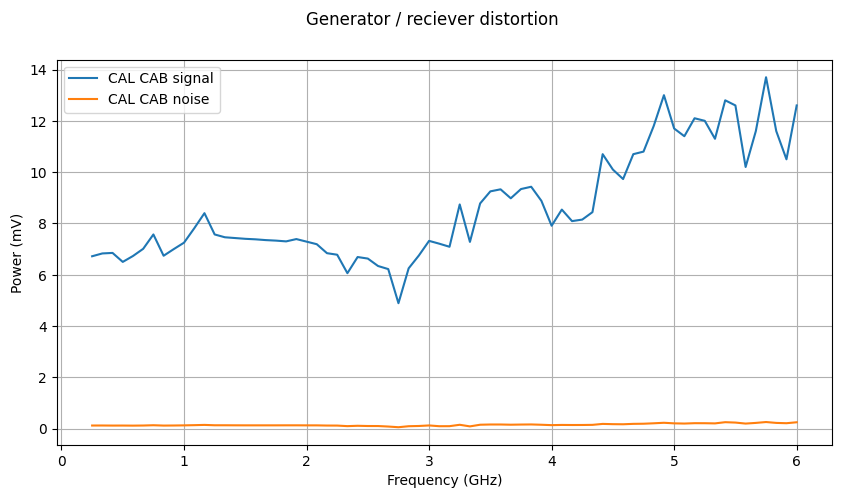

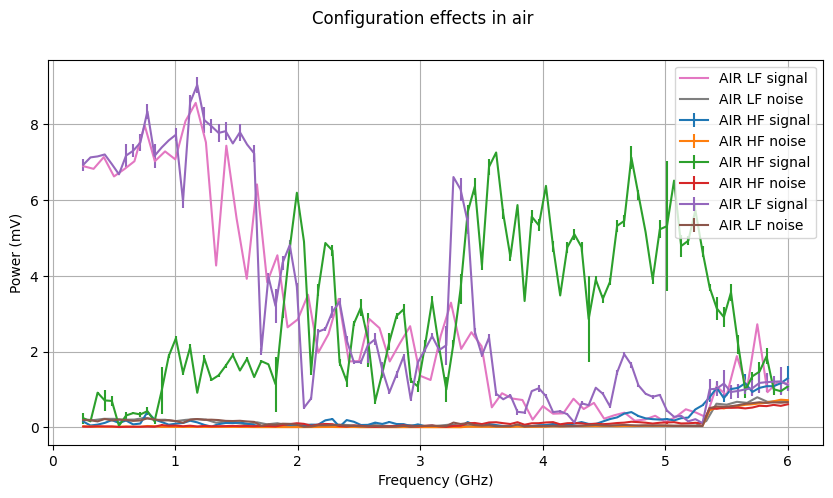

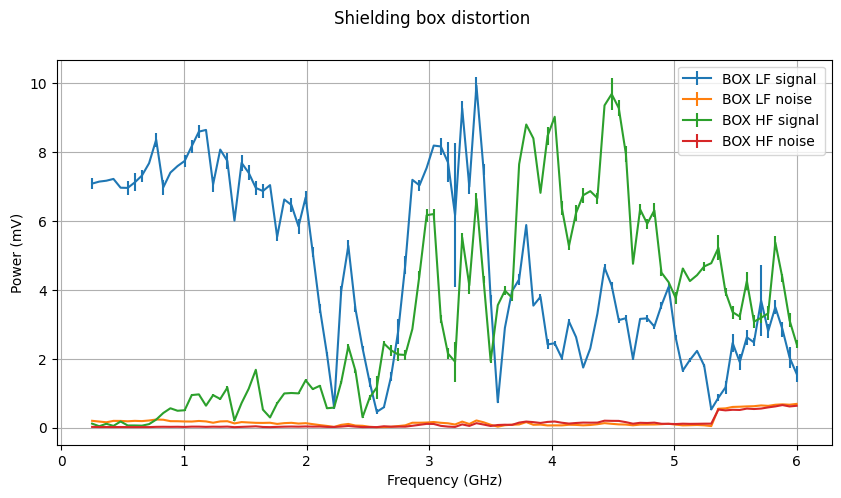

In [105]:

def calibration_effects(sample : str, title : str):
        '''
                This function draws all the graphs of a selected sample,
                it is optimized for drawing calibration effects where the 
                runs are few
        '''
        subset = df[df['sample'] == sample]
        fig, ax = plt.subplots()
        
        subset.groupby(subset['id']).apply(utils.plot_this, ax, include_groups=False)

        # set y scale to logarithmic
        # ax.set_yscale('log')
        
        fig.suptitle(title)
        ax.grid(True)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Power (mV)')
        ax.legend()


calibration_effects('CAL', 'Generator / reciever distortion')
calibration_effects('AIR', 'Configuration effects in air')
calibration_effects('BOX', 'Shielding box distortion')

Dal grafico "Generator \ Reciever distortion" emerge che il segnale non ha lo stesso gain su tutta la banda, andrà quindi rinormalizzato per eliminare l'amplificazione del segnale da parte dei trasmettitori in questo modo:

$$
 normalized\_signal = \frac{signal}{cal\_signal - cal\_noise}
$$

Per eliminare effetti dovuti alle fluttuazioni del segnale sarebbe da interpolare il gain con una funzione continua.

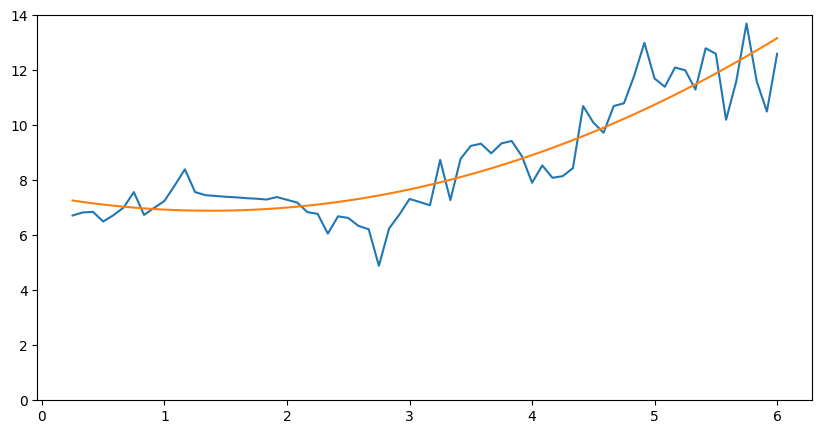

In [117]:
def getGain():
    '''
        Get the gain for each frequency by interpolating
        the measures as a polynomial
    '''
    subset = df[df['sample'] == 'CAL']
    x = subset['frequency_GHz'].values.tolist()
    y = subset['peak_mV'].values.tolist()
    coeff = np.polyfit(x,y,2)

    ax = plt.subplot()
    ax.plot(x,y)
    ax.plot(x, np.polyval(coeff, x))

    ax.set_ylim(0,14)
    return coeff

getGain()